In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from tidegauge_functions import read_GPS_nam14_UNAVCO,convert_trend_toyearly
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
datum = 'KULU'
ext = '.csv'
meth = '.cwu.nam14'
dir_in = 'data/GPS'

In [3]:
pattern = os.path.join(dir_in, datum + meth + ext)
print(pattern)

data/GPS\KULU.cwu.nam14.csv


In [4]:
filenames = sorted(glob.glob(pattern))  # , key=alphanum_key)

In [5]:
for f, filepath in enumerate(filenames):
    df = read_GPS_nam14_UNAVCO(filepath)
    print(f'\n\n{filepath}')
    print(df.head())



data/GPS\KULU.cwu.nam14.csv
            North  East  Vertical  NorthSTD  EastSTD  VerticalSTD Quality
Date                                                                     
1996-07-25   0.00  0.00      0.00      3.08     2.19         9.93   repro
1996-07-26  -1.07 -0.16     -0.64      3.72     2.64        12.29   repro
1996-07-27   0.16 -2.04     11.45      4.15     2.93        13.92   repro
1996-07-28  -0.53 -0.65     11.62      3.05     2.19        10.03   repro
1996-07-29  -5.19 -0.85      5.00      2.90     2.07         9.80   repro


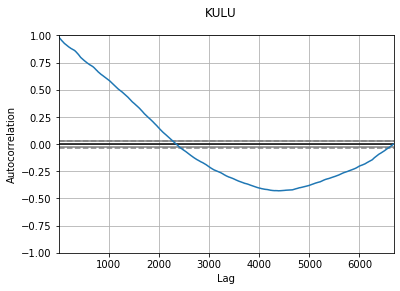

In [6]:
for f, filepath in enumerate(filenames):
    df = read_GPS_nam14_UNAVCO(filepath)
    autocorrelation_plot(df['Vertical'])
    plt.suptitle(f"{filepath[-18:-14]}")
    plt.show()

In [ ]:

for f, filepath in enumerate(filenames):
    df = read_GPS_nam14_UNAVCO(filepath) 
    df_monthly = df.dropna().resample('1M').mean()
    model = ARIMA(df_monthly['Vertical'].dropna(), order=(4,1,0))
    model_fit = model.fit(disp=0)
    print(model_fit.summary())
    # plot residual errors
    residuals = DataFrame(model_fit.resid)
    residuals.plot()
    plt.suptitle(f"{filepath[-18:-14]}")
    plt.show()
    residuals.plot(kind='kde')
    plt.suptitle(f"{filepath[-18:-14]}")
    plt.show()
    print(residuals.describe())

In [ ]:
#Rolling Forecast ARIMA Model
def ARIMA_GPS(df, var, site):
    for f, filepath in enumerate(filenames):
        df = read_GPS_nam14_UNAVCO(filepath)
        df_monthly = df.dropna().resample('1M').mean()
        X = df_monthly[var].dropna()
        size = int(len(X) * 0.66)
        train, test = X[0:size], X[size:len(X)]
        history = [x for x in train]
        predictions = list()
        for t in range(len(test)):
            model = ARIMA(history, order=(5,1,0))
            model_fit = model.fit(disp=0)
            output = model_fit.forecast()
            yhat = output[0]
            predictions.append(yhat)
            obs = test[t]
            history.append(obs)
            print('predicted=%f, expected=%f' % (yhat, obs))
        error = mean_squared_error(test, predictions)
        print('Test MSE: %.3f' % error)
        # plot
        plt.plot(test)
        plt.plot(predictions, color='red')
        ax.set_title(f"% error = {error}");
        plt.suptitle(f"{site} ARIMA")

In [ ]:
ARIMA_GPS(df, 'Vertical', filepath[-18:-14])

In [ ]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

X = df.Vertical
days_in_year = 365
differenced = difference(X, days_in_year)
# fit model
model = ARIMA(differenced, order=(7,0,1))
model_fit = model.fit(disp=0)
# print summary of fit model
print(model_fit.summary())
# multi-step out-of-sample forecast
forecast = model_fit.forecast(steps=365)[0]
# invert the differenced forecast to something usable
history = [x for x in X]
day = 1
for yhat in forecast:
    inverted = inverse_difference(history, yhat, days_in_year)
    print('Day %d: %f' % (day, inverted))
    history.append(inverted)
    day += 1

In [ ]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df.Vertical[:6000]
test = df.Vertical[6000:]


# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(4, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(682, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [19]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(df, var, window):

    #Determing rolling statistics
    df[var] = df[var].dropna()
    rolmean = df[var].dropna().rolling(window).mean()
    rolstd = df[var].dropna().rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(df[var], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[var], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 

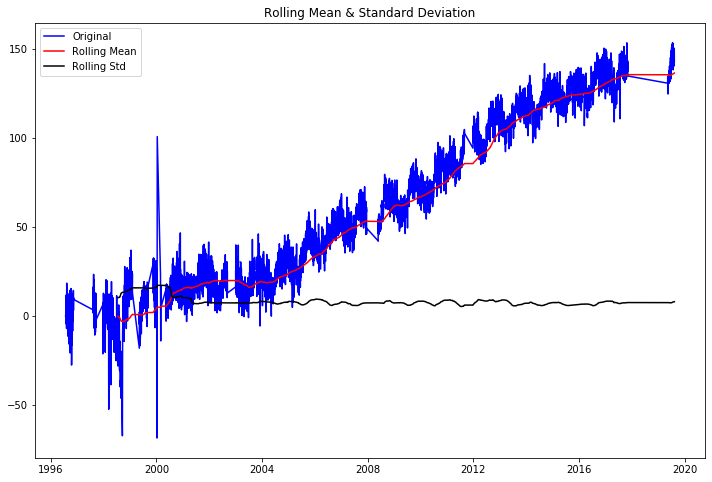

Results of Dickey-Fuller Test:
Test Statistic                   -0.458775
p-value                           0.899813
#Lags Used                       30.000000
Number of Observations Used    6651.000000
Critical Value (1%)              -3.431334
Critical Value (5%)              -2.861975
Critical Value (10%)             -2.567001
dtype: float64


In [20]:
test_stationarity(df, 'Vertical', 365)

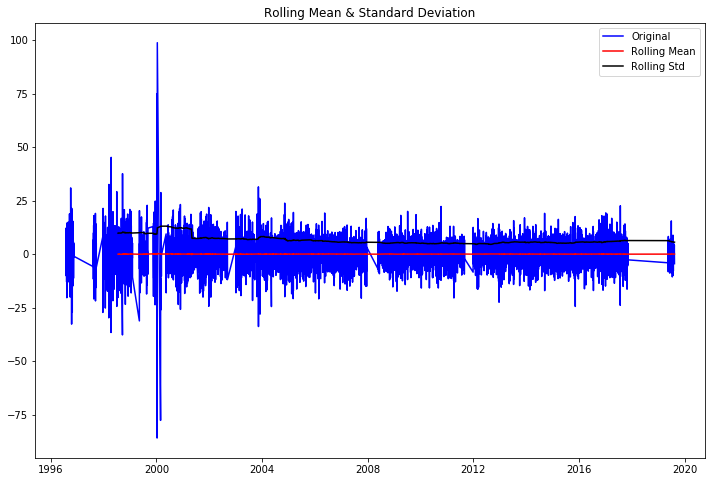

Results of Dickey-Fuller Test:


MissingDataError: exog contains inf or nans

In [21]:
df['Vert_first_dif'] = df.Vertical - df.Vertical.shift(1)
test_stationarity(df, 'Vert_first_dif' , 365)


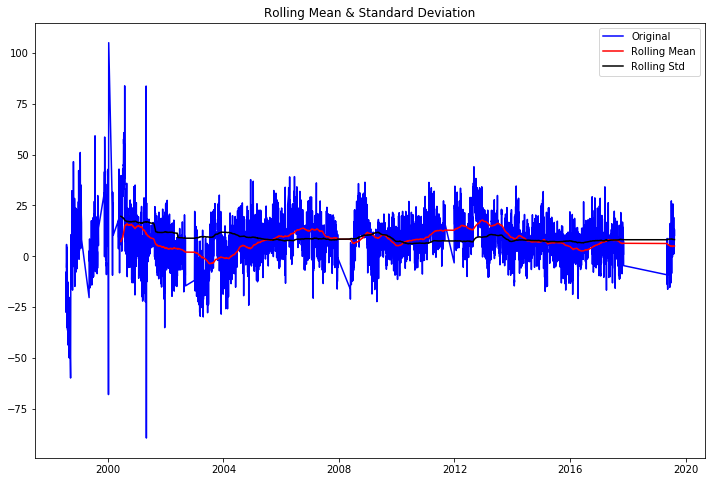

Results of Dickey-Fuller Test:


MissingDataError: exog contains inf or nans

In [23]:
df['Vert_seasonal_dif'] = df.Vertical - df.Vertical.shift(365)
test_stationarity(df, 'Vert_seasonal_dif' , 365)

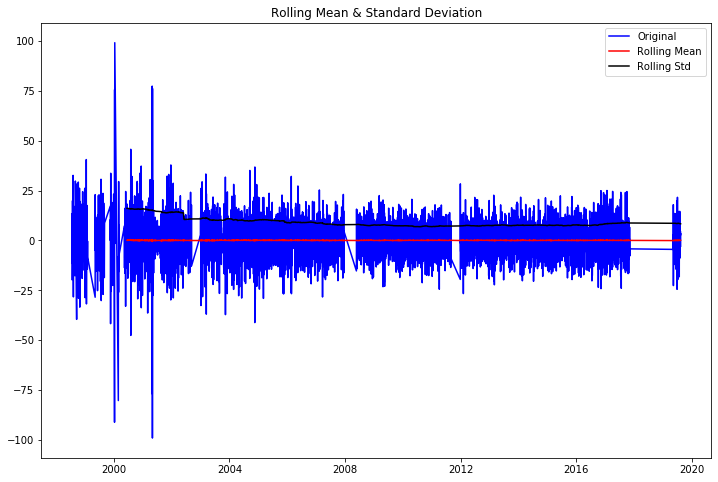

Results of Dickey-Fuller Test:


MissingDataError: exog contains inf or nans

In [28]:
df['Vert_seasonal_first_dif'] = df.Vert_first_dif - df.Vert_first_dif.shift(365)
test_stationarity(df, 'Vert_seasonal_first_dif', 365)

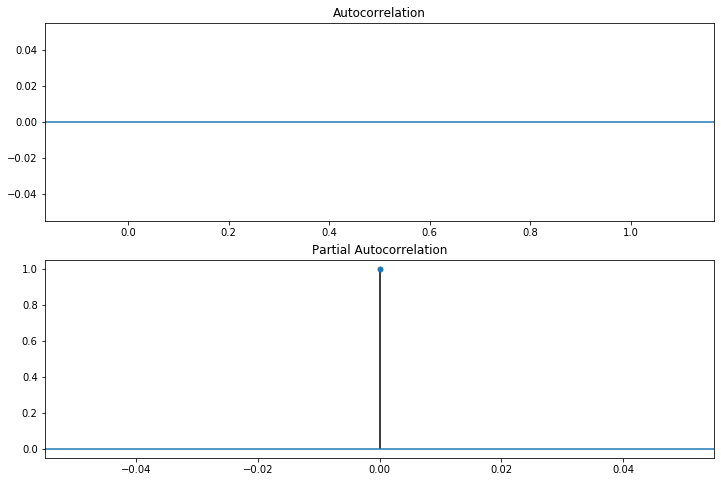

In [34]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.Vert_seasonal_dif.iloc[13:], lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.Vert_seasonal_dif.iloc[13:], lags=30, ax=ax2)

In [ ]:
model = sm.tsa.statespace.SARIMAX(df.Vertical, trend='n', order=(4,1,0), seasonal_order=(1,1,1,365))
results = model.fit()
print(results.summary())

C:\Users\jhsan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jhsan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
forecast = model_fit.forecast()[0]

In [ ]:
for f, filepath in enumerate(filenames):
    df = read_GPS_nam14_UNAVCO(filepath)
    # fit model
    model = ARIMA(df[['Vertical']].dropna(), order=(4,1,0))
    model_fit = model.fit(disp=0)
    print(model_fit.summary())

In [ ]:
site_name_array = []
for f, filepath in enumerate(filenames):
    df = read_GPS_nam14_UNAVCO(filepath)
    model = ARIMA(df['Vertical'].dropna(), order=(4, 1, 0))
    site_name_array.append(filepath[-18:-14])
    results_ARIMA = model.fit(disp=-1)  
    plt.plot(df['Vertical'].dropna())
    plt.plot(results_ARIMA.fittedvalues, color='red')
    plt.suptitle(f"{site}")